<h1><center>Part B: Text Classification</center></h1>

**<center>This project aims at building CNNs and RNNs at word and character levels to predict the categories of paragraphs from Wikipedia. <center>**


## Loading dependencies

In [ ]:
from tensorflow.keras import Model, layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import collections
import time
import csv
import re

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Global constants

The project requires us to keep certain parameters constant during the training of the neural networks

In [ ]:
MAX_DOCUMENT_LENGTH = 100

N_FILTERS = 10
FILTER_SHAPE_1 = [20, 256]
FILTER_SHAPE_2 = [20, 1]
FILTER_SHAPE_3 = [20, 20]
 
POOLING_WINDOW = 4
POOLING_STRIDE = 2

EMBEDDING_SIZE = 20
HIDDEN_SIZE = 20

MAX_LABEL = 15

BATCH_SIZE = 128
ONE_HOT_SIZE = 256
EPOCHS = 250
LR = 0.01
DROP_RATES = [0.4, 0.8]

# For same results each time
seed = 10
tf.random.set_seed(seed)

#Q6
typeLayers = ["GRU", "RNN", "LTSM"]
numLayers = [1, 2]
useClipping = [False, True]

## Defining Common Functions

In [ ]:
# Training and Testing function
def train_and_test(model, isCNN, isCharacter, dropRate = 0.0):

  # Choose optimizer and loss function for training
  if (isCNN):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=LR)

  else:
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)


  # Select metrics to measure the loss and the accuracy of the model. 
  # These metrics accumulate the values over epochs and then print the overall result.
  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

  test_loss = tf.keras.metrics.Mean(name='test_loss')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

  #############################
  # Training and testing the model
  train_cost = []
  test_acc = []

  with tf.device('/device:GPU:0'):
    start_time = time.time()
    for epoch in range(EPOCHS):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        if (isCharacter):
          for images, labels in train_ds_char:
              train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy, dropRate)

          for images, labels in test_ds_char:
              test_step(model, images, labels, loss_object, optimizer, test_loss, test_accuracy, dropRate)

        else:
          for images, labels in train_ds_word:
              train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy, dropRate)

          for images, labels in test_ds_word:
              test_step(model, images, labels, loss_object, optimizer, test_loss, test_accuracy, dropRate)             

        train_cost.append(train_loss.result())
        test_acc.append(test_accuracy.result())
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        if((epoch+1)%10 == 0):
          print (template.format(epoch+1,
                                train_loss.result(),
                                train_accuracy.result(),
                                test_loss.result(),
                                test_accuracy.result()))
          
    end_time = time.time()  
    running_time = end_time - start_time
    print("--- TRAINING COMPLETE --- \n\n")


    return train_cost, test_acc, running_time


# Defining the training function
def train_step(model, x, label, LOSS_OBJECT, OPTIMIZER, TRAIN_LOSS, TRAIN_ACC, drop_rate=0.0):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = LOSS_OBJECT(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        OPTIMIZER.apply_gradients(zip(gradients, model.trainable_variables))
        
    TRAIN_LOSS(loss)
    TRAIN_ACC(label, out)

# Defining the testing function
def test_step(model, x, label, LOSS_OBJECT, OPTIMIZER, TEST_LOSS, TEST_ACC, drop_rate=0.0):
    out = model(x, drop_rate)
    t_loss = LOSS_OBJECT(label, out)
    TEST_LOSS(t_loss)
    TEST_ACC(label, out)




## Character Loading Functions


In [ ]:
def vocabulary(strings):
  chars = sorted(list(set(list(''.join(strings)))))
  char_to_ix = { ch:i for i,ch in enumerate(chars) }
  vocab_size = len(chars)
  return vocab_size, char_to_ix

In [ ]:
def preprocess_by_char(strings, char_to_ix, MAX_LENGTH):
  data_chars = [list(d.lower()) for _, d in enumerate(strings)]
  for i, d in enumerate(data_chars):
    if len(d)>MAX_LENGTH:
      d = d[:MAX_LENGTH]
    elif len(d) < MAX_LENGTH:
      d += [' '] * (MAX_LENGTH - len(d))
          
  data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
  for i in range(len(data_chars)):
    for j in range(MAX_LENGTH):
      data_ids[i, j] = char_to_ix[data_chars[i][j]]
  return np.array(data_ids)

In [ ]:
def read_data_chars():
  x_train, y_train, x_test, y_test = [], [], [], []
  cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
  with open('./train_medium.csv', encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      data = cop.sub("", row[1])
      x_train.append(data)
      y_train.append(int(row[0]))

  with open('./test_medium.csv', encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      data = cop.sub("", row[1])
      x_test.append(data)
      y_test.append(int(row[0]))


  vocab_size, char_to_ix = vocabulary(x_train+x_test)
  x_train = preprocess_by_char(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
  y_train = np.array(y_train)
  x_test = preprocess_by_char(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
  y_test = np.array(y_test)

  x_train = tf.constant(x_train, dtype=tf.int64)
  y_train = tf.constant(y_train, dtype=tf.int64)
  x_test = tf.constant(x_test, dtype=tf.int64)
  y_test = tf.constant(y_test, dtype=tf.int64)

  return x_train, y_train, x_test, y_test

## Data Loading Functions

In [ ]:
def clean_str(text):
  text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
  text = re.sub(r"\s{2,}", " ", text)
  text = text.strip().lower()

  return text

In [ ]:
def build_word_dict(contents):
  words = list()
  for content in contents:
    for word in word_tokenize(clean_str(content)):
        words.append(word)

  word_counter = collections.Counter(words).most_common()
  word_dict = dict()
  word_dict["<pad>"] = 0
  word_dict["<unk>"] = 1
  word_dict["<eos>"] = 2
  for word, _ in word_counter:
    word_dict[word] = len(word_dict)
  return word_dict

In [ ]:
def preprocess_by_word(contents, word_dict, document_max_len):
  x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
  x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
  x = list(map(lambda d: d + [word_dict["<eos>"]], x))
  x = list(map(lambda d: d[:document_max_len], x))
  x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
  return x

In [ ]:
def read_data_words():
  x_train, y_train, x_test, y_test = [], [], [], []
  cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
  with open('./train_medium.csv', encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      data = cop.sub("", row[1])
      x_train.append(data)
      y_train.append(int(row[0]))

  with open('./test_medium.csv', encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      data = cop.sub("", row[1])
      x_test.append(data)
      y_test.append(int(row[0]))

  word_dict = build_word_dict(x_train+x_test)
  x_train = preprocess_by_word(x_train, word_dict, MAX_DOCUMENT_LENGTH)
  y_train = np.array(y_train)
  x_test = preprocess_by_word(x_test, word_dict, MAX_DOCUMENT_LENGTH)
  y_test = np.array(y_test)

  x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
  x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
  x_train = tf.constant(x_train, dtype=tf.int64)
  y_train = tf.constant(y_train, dtype=tf.int64)
  x_test = tf.constant(x_test, dtype=tf.int64)
  y_test = tf.constant(y_test, dtype=tf.int64)

  vocab_size = tf.get_static_value(tf.reduce_max(x_train))
  vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
  return x_train, y_train, x_test, y_test, vocab_size

### Loading data

We load the data word-by-word and character-by-character

In [ ]:
# Loading data word-by-word
X_train_word, y_train_word, X_test_word, y_test_word, vocab_size_word = read_data_words()
# Use `tf.data` to batch and shuffle the dataset
train_ds_word = tf.data.Dataset.from_tensor_slices((X_train_word, y_train_word)).shuffle(10000).batch(BATCH_SIZE)
test_ds_word = tf.data.Dataset.from_tensor_slices((X_test_word, y_test_word)).batch(BATCH_SIZE)

In [ ]:
# Loading data character-by-character
X_train_char, y_train_char, X_test_char, y_test_char = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset
train_ds_char = tf.data.Dataset.from_tensor_slices((X_train_char, y_train_char)).shuffle(10000).batch(BATCH_SIZE)
test_ds_char = tf.data.Dataset.from_tensor_slices((X_test_char, y_test_char)).batch(BATCH_SIZE)

## Question 1 

###1A. Designing a character CNN classifier

In [ ]:
# Building the model
tf.keras.backend.set_floatx('float32')
class CharCNN(Model):
    def __init__(self, vocab_size=256):
        super(CharCNN, self).__init__()
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE_1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE_2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.0):
        # forward
        x = tf.one_hot(x, ONE_HOT_SIZE)
        x = x[..., tf.newaxis] 
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

In [ ]:
# Building the model object
model = CharCNN(256)

# Training and testing the model
train_cost_q1 = []
test_acc_q1 = []

train_cost_q1, test_acc_q1, time_q1 = train_and_test(model, True, True)

Epoch 10, Loss: 2.6294424533843994, Accuracy: 0.19589285552501678, Test Loss: 2.6263489723205566, Test Accuracy: 0.19857142865657806
Epoch 20, Loss: 2.3252878189086914, Accuracy: 0.2455357164144516, Test Loss: 2.3155391216278076, Test Accuracy: 0.2542857229709625
Epoch 30, Loss: 1.9062949419021606, Accuracy: 0.4000000059604645, Test Loss: 1.9540868997573853, Test Accuracy: 0.37857142090797424
Epoch 40, Loss: 1.561215877532959, Accuracy: 0.5114285945892334, Test Loss: 1.6518940925598145, Test Accuracy: 0.47428572177886963
Epoch 50, Loss: 1.3066970109939575, Accuracy: 0.5776785612106323, Test Loss: 1.450586199760437, Test Accuracy: 0.5328571200370789
Epoch 60, Loss: 1.1353436708450317, Accuracy: 0.635357141494751, Test Loss: 1.327382206916809, Test Accuracy: 0.5642856955528259
Epoch 70, Loss: 0.9999760985374451, Accuracy: 0.678928554058075, Test Loss: 1.276173710823059, Test Accuracy: 0.5942857265472412
Epoch 80, Loss: 0.9269211292266846, Accuracy: 0.7028571367263794, Test Loss: 1.195232

###1B. Plotting the 
- entropy cost on the training data against epochs 
- the accuracy on the testing data against epochs



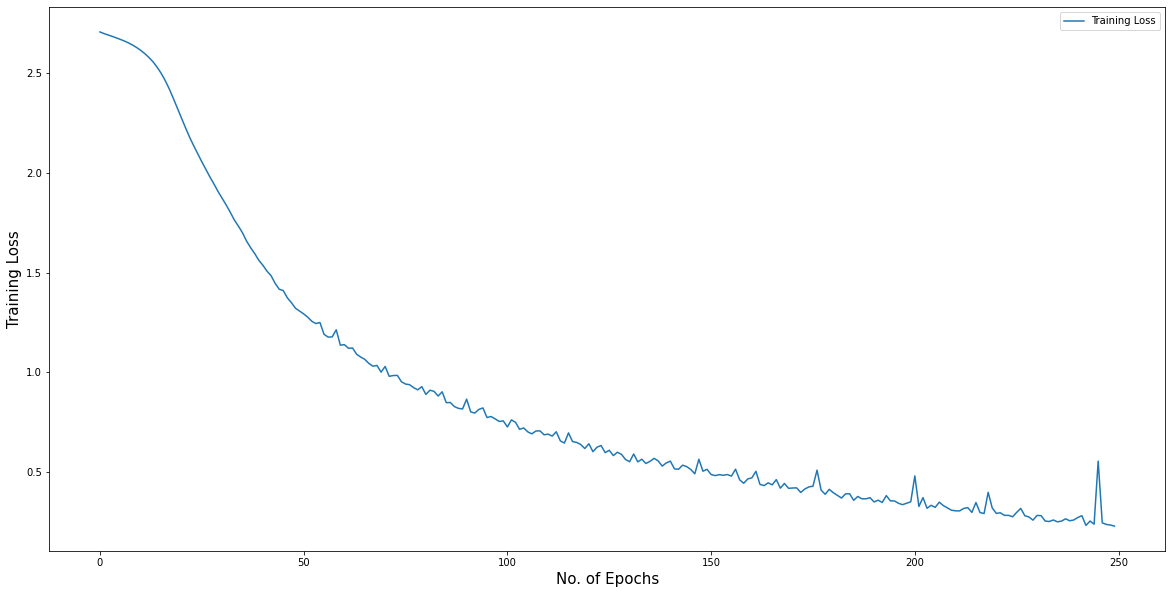

In [ ]:
# Plotting training loss vs epochs
plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), train_cost_q1, label="Training Loss")
plt.xlabel('No. of Epochs', fontsize=15)
plt.ylabel('Training Loss', fontsize=15)
plt.legend()
plt.show()

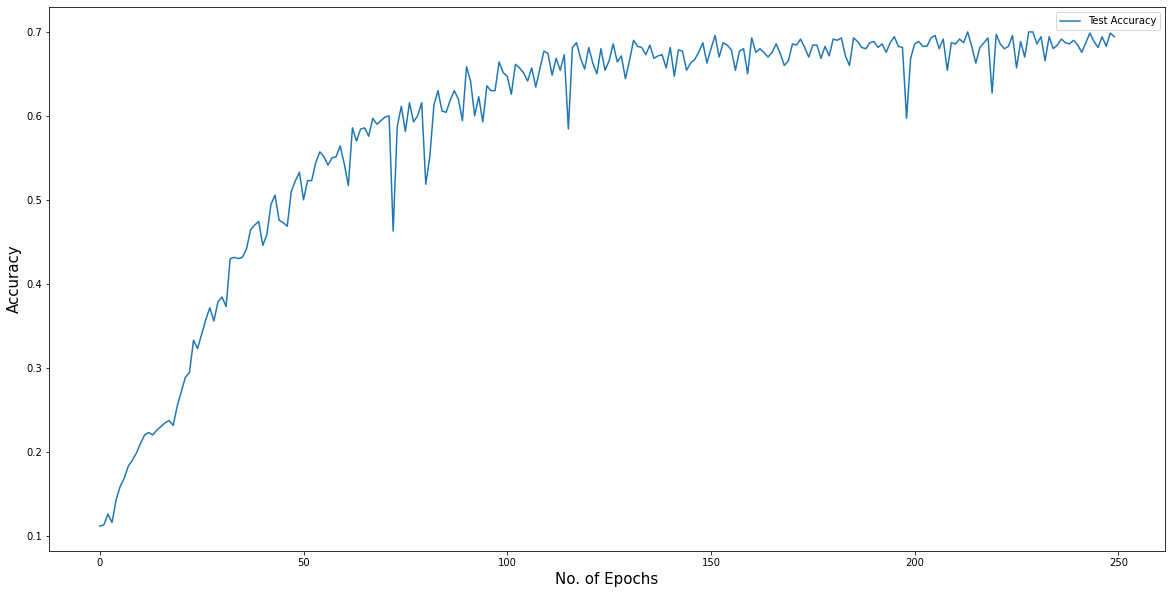

In [ ]:
# Plotting testing accuracy vs epochs
plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), test_acc_q1, label="Test Accuracy")
plt.xlabel('No. of Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

It can be seen that the Character CNN model has 
- a final test accuracy of approx. 69.4% 
- a final train loss of approx. 1.214

## Question 2


###A. Designing a word CNN classifier

In [ ]:
# Building the model
tf.keras.backend.set_floatx('float32')
class WordCNN(Model):
    def __init__(self, vocab_size=256):
        super(WordCNN, self).__init__()
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE_3, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE_2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.0):
        # forward
        x = self.embedding(x)
        x = x[..., tf.newaxis]
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

In [ ]:
# Building the model object
model = WordCNN(vocab_size_word)

# Training and testing the model
train_cost_q2 = []
test_acc_q2 = []

train_cost_q2, test_acc_q2, time_q2 = train_and_test(model, True, False)

Epoch 10, Loss: 2.6748576164245605, Accuracy: 0.0714285746216774, Test Loss: 2.674368143081665, Test Accuracy: 0.0714285746216774
Epoch 20, Loss: 2.6506242752075195, Accuracy: 0.07124999910593033, Test Loss: 2.6497256755828857, Test Accuracy: 0.07428571581840515
Epoch 30, Loss: 2.6411118507385254, Accuracy: 0.07696428894996643, Test Loss: 2.639655351638794, Test Accuracy: 0.08285713940858841
Epoch 40, Loss: 2.6365902423858643, Accuracy: 0.08892857283353806, Test Loss: 2.6344683170318604, Test Accuracy: 0.09142857044935226
Epoch 50, Loss: 2.6274452209472656, Accuracy: 0.09660714119672775, Test Loss: 2.6231205463409424, Test Accuracy: 0.09714286029338837
Epoch 60, Loss: 2.607168674468994, Accuracy: 0.10160714387893677, Test Loss: 2.6020872592926025, Test Accuracy: 0.11999999731779099
Epoch 70, Loss: 2.5969367027282715, Accuracy: 0.10464286059141159, Test Loss: 2.5916855335235596, Test Accuracy: 0.09714286029338837
Epoch 80, Loss: 2.5925328731536865, Accuracy: 0.1128571406006813, Test Los

###2B. Plotting the 
- entropy cost on the training data against epochs 
- the accuracy on the testing data against epochs



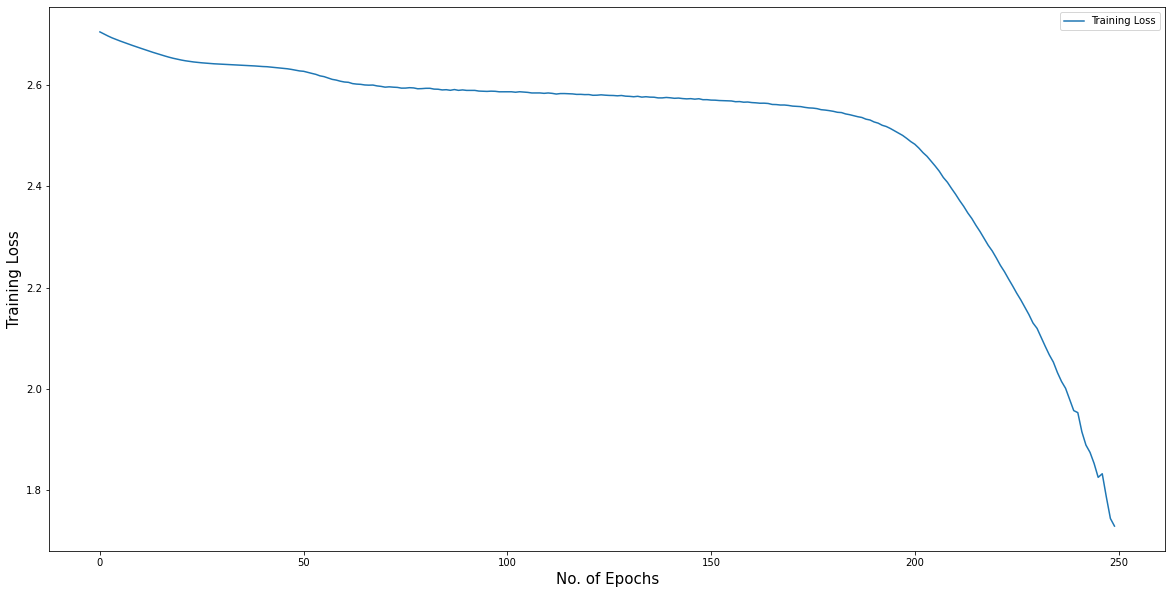

In [ ]:
# Plotting training loss vs epochs
plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), train_cost_q2, label="Training Loss")
plt.xlabel('No. of Epochs', fontsize=15)
plt.ylabel('Training Loss', fontsize=15)
plt.legend()
plt.show()

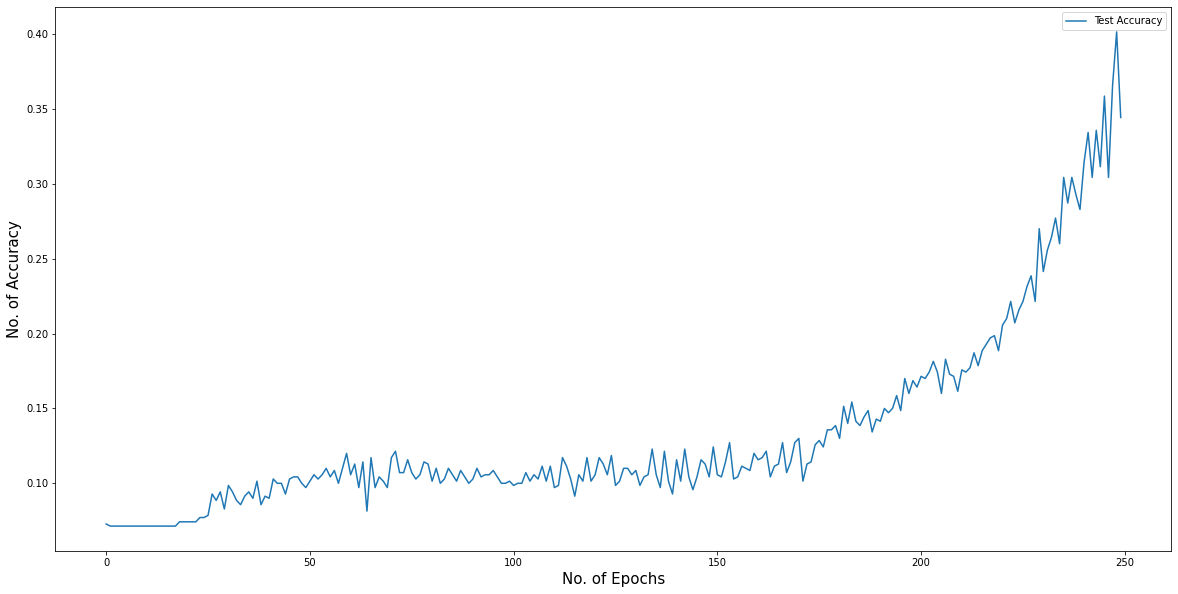

In [ ]:
# Plotting testing accuracy vs. epochs
plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), test_acc_q2, label="Test Accuracy")
plt.xlabel('No. of Epochs', fontsize=15)
plt.ylabel('No. of Accuracy', fontsize=15)
plt.legend()
plt.show()

__Conclusion:__ We can see that the Word CNN model has a final test accuracy of approximately __33.0%__ and a final train loss of approximately __1.75__

It can be seen that the Word CNN model has 
- a final test accuracy of approx. 34.4% 
- a final train loss of approx. 1.729

## Question 3

###3A. Designing a Character RNN classifier

In [ ]:
# Build model
tf.keras.backend.set_floatx('float32')
class CharacterRNN(Model):
    def __init__(self, hidden_dim=20, cell_type="gru", rnn_layers=1):
        super(CharacterRNN, self).__init__()

        # Pick RNN cell type
        if cell_type == "rnn":
          cell = layers.SimpleRNNCell
        elif cell_type == "lstm":
          cell = layers.LSTMCell
        else:
          cell = layers.GRUCell

        # Repeat if more than one layer
        if rnn_layers > 1:
          cells = []
          for i in range(rnn_layers):
            cells.append(cell(hidden_dim))
          cells = layers.StackedRNNCells(cells)
        else:
          cells = cell(hidden_dim)

        # Weight variables and RNN cell
        self.rnn = layers.RNN(cells, unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate=0.0):
        # forward logic
        x = tf.one_hot(x, ONE_HOT_SIZE)
        encoding = self.rnn(x)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
# Building the model object
model = CharacterRNN(HIDDEN_SIZE)

# Training and testing the model
train_cost_q3 = []
test_acc_q3 = []

train_cost_q3, test_acc_q3, time_q3 = train_and_test(model, False, True)

Epoch 10, Loss: 1.160994052886963, Accuracy: 0.5876785516738892, Test Loss: 1.31112539768219, Test Accuracy: 0.5285714268684387
Epoch 20, Loss: 0.7961504459381104, Accuracy: 0.7364285588264465, Test Loss: 1.0512350797653198, Test Accuracy: 0.6571428775787354
Epoch 30, Loss: 0.6103001236915588, Accuracy: 0.7976785898208618, Test Loss: 1.0089948177337646, Test Accuracy: 0.6828571557998657
Epoch 40, Loss: 0.6170050501823425, Accuracy: 0.7967857122421265, Test Loss: 1.0551024675369263, Test Accuracy: 0.691428542137146
Epoch 50, Loss: 0.41775110363960266, Accuracy: 0.8660714030265808, Test Loss: 1.116634488105774, Test Accuracy: 0.6899999976158142
Epoch 60, Loss: 0.4732409417629242, Accuracy: 0.8496428728103638, Test Loss: 1.1440881490707397, Test Accuracy: 0.6985714435577393
Epoch 70, Loss: 0.41643646359443665, Accuracy: 0.864464282989502, Test Loss: 1.1550312042236328, Test Accuracy: 0.6957142949104309
Epoch 80, Loss: 0.354483962059021, Accuracy: 0.8862500190734863, Test Loss: 1.179576992

###3B. Plotting the 
- entropy cost on the training data against epochs 
- the accuracy on the testing data against epochs



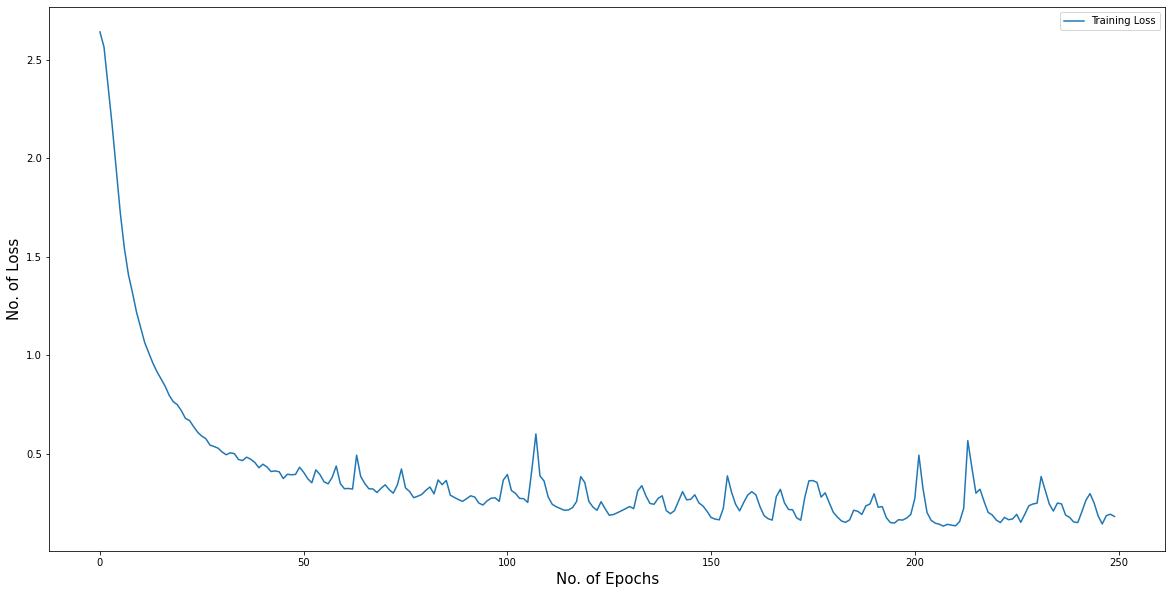

In [ ]:
# Plotting training loss vs epochs
plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), train_cost_q3, label="Training Loss")
plt.xlabel('No. of Epochs', fontsize=15)
plt.ylabel('No. of Loss', fontsize=15)
plt.legend()
plt.show()

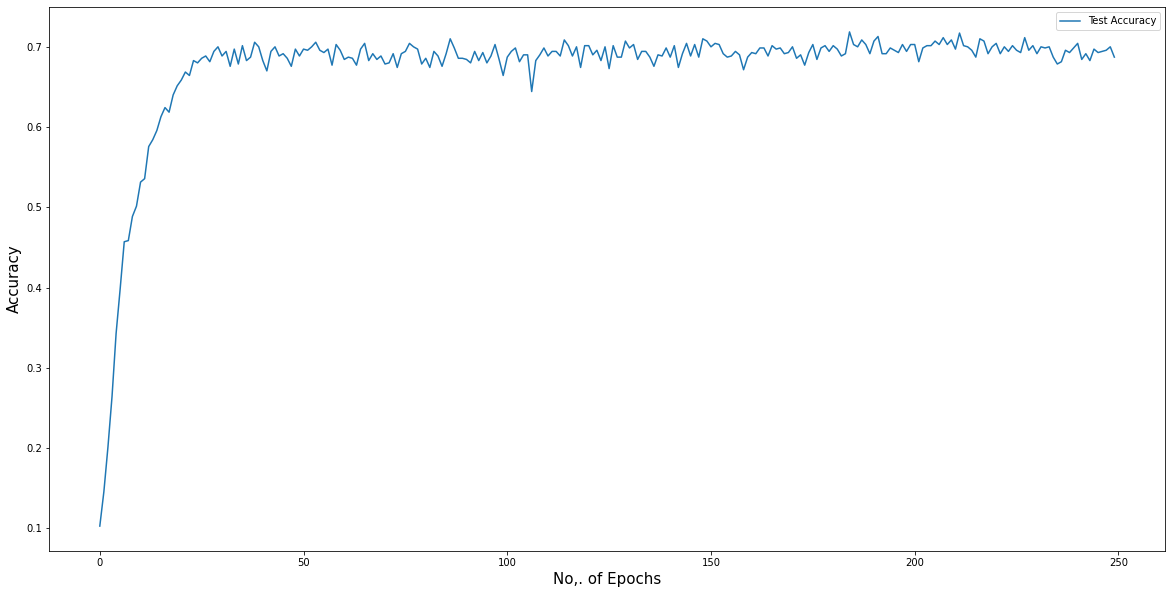

In [ ]:
# Plotting testing accuracy vs epochs
plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), test_acc_q3, label="Test Accuracy")
plt.xlabel('No,. of Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

It can be seen that the Character RNN model has 
- a final test accuracy of approx. 71.4% 
- a final train loss of approx. 0.353

## Question 4

###A. Designing a word RNN classifier

In [ ]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20, cell_type="gru", rnn_layers=1):
        super(WordRNN, self).__init__()

        # Pick RNN cell type
        if cell_type == "rnn":
          cell = layers.SimpleRNNCell
        elif cell_type == "lstm":
          cell = layers.LSTMCell
        else:
          cell = layers.GRUCell

        # Repeat if more than one layer
        if rnn_layers > 1:
          cells = []
          for i in range(rnn_layers):
            cells.append(cell(hidden_dim))
          cells = layers.StackedRNNCells(cells)
        else:
          cells = cell(hidden_dim)

        # Weight variables and RNN cell
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        self.rnn = layers.RNN(cells, unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate=0.0):
        # forward logic
        x = self.embedding(x)
        encoding = self.rnn(x)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
# Building the model object
model = WordRNN(vocab_size_word, HIDDEN_SIZE)

# Training and testing the model
train_cost_q4 = []
test_acc_q4 = []

train_cost_q4, test_acc_q4, time_q4 = train_and_test(model, False, False)

Epoch 10, Loss: 0.0484657920897007, Accuracy: 0.989642858505249, Test Loss: 0.565983235836029, Test Accuracy: 0.868571400642395
Epoch 20, Loss: 0.015832122415304184, Accuracy: 0.996071457862854, Test Loss: 0.6642118096351624, Test Accuracy: 0.8671428561210632
Epoch 30, Loss: 0.001367017743177712, Accuracy: 1.0, Test Loss: 0.6584781408309937, Test Accuracy: 0.8742856979370117
Epoch 40, Loss: 0.0005820444202981889, Accuracy: 1.0, Test Loss: 0.7364227175712585, Test Accuracy: 0.8700000047683716
Epoch 50, Loss: 0.00034595030592754483, Accuracy: 1.0, Test Loss: 0.7919943928718567, Test Accuracy: 0.868571400642395
Epoch 60, Loss: 0.00022829411318525672, Accuracy: 1.0, Test Loss: 0.8325620293617249, Test Accuracy: 0.8714285492897034
Epoch 70, Loss: 0.00015797570813447237, Accuracy: 1.0, Test Loss: 0.8678510785102844, Test Accuracy: 0.8671428561210632
Epoch 80, Loss: 0.00011187260679434985, Accuracy: 1.0, Test Loss: 0.9007237553596497, Test Accuracy: 0.8742856979370117
Epoch 90, Loss: 8.183157

###4B. Plotting the 
- entropy cost on the training data against epochs 
- the accuracy on the testing data against epochs



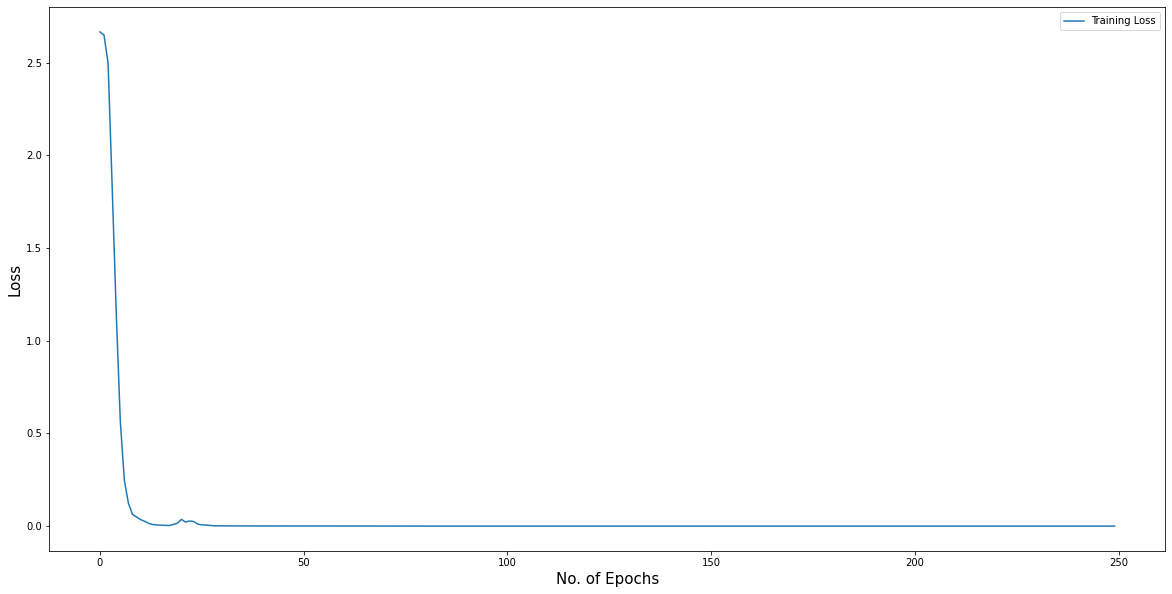

In [ ]:
# Plotting training loss vs epochs
plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), train_cost_q4, label="Training Loss")
plt.xlabel('No. of Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.show()

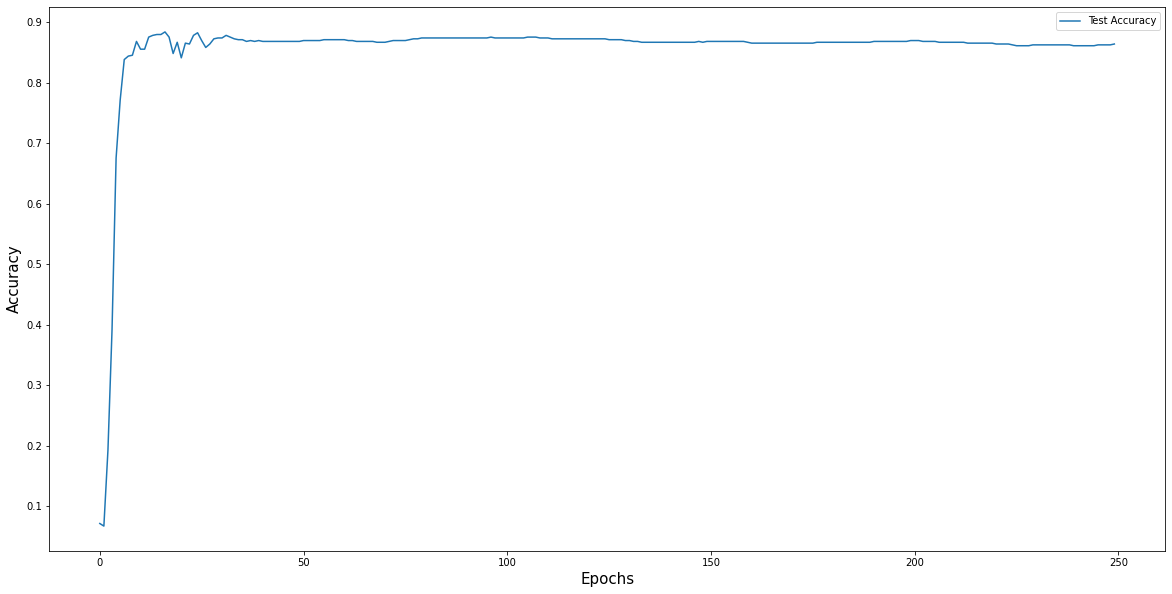

In [ ]:
# Plotting testing accuracy vs epochs
plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), test_acc_q4, label="Test Accuracy")
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

It can be seen that the Word RNN model has 
- a final test accuracy of approx. 86.4% 
- a final train loss of approx. 1.728e-06

## Question 5


###5A. Comparing the test accuracies and running times of the 4 previous models. 

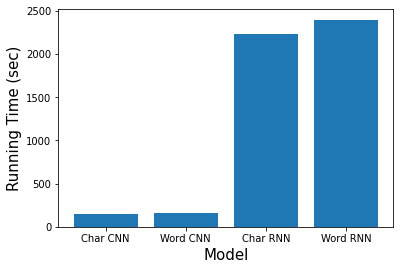

In [ ]:
# Plotting the running times of the previous 4 models
plt.xlabel('Model', fontsize=15)
plt.ylabel('Running Time (sec)', fontsize=15)

model_list = ["Char CNN", "Word CNN", "Char RNN", "Word RNN"]
time_list = [time_q1, time_q2, time_q3, time_q4]

plt.bar(model_list, time_list, align='center');
plt.show()

From the bar graph, it can clearly be seen that RNN models have a much longer training time than CNN models


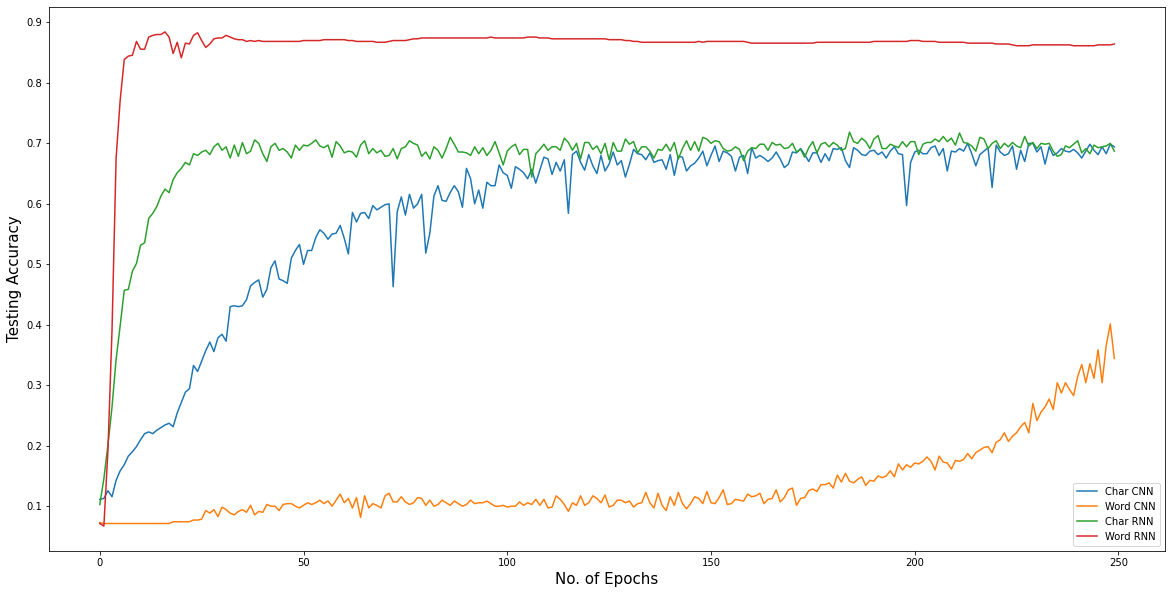

In [ ]:
# Plotting test accuracies vs epochs for each model
plt.figure(figsize=(20,10))

plt.plot(np.arange(EPOCHS), test_acc_q1, label="Char CNN")
plt.plot(np.arange(EPOCHS), test_acc_q2, label="Word CNN")
plt.plot(np.arange(EPOCHS), test_acc_q3, label="Char RNN")
plt.plot(np.arange(EPOCHS), test_acc_q4, label="Word RNN")

plt.xlabel('No. of Epochs', fontsize=15)
plt.ylabel('Testing Accuracy', fontsize=15)
plt.legend()
plt.show()

It can be see that RNN models perform better than CNN models as they have much better accuracy.

Also, CNN and RNN models based on word-level classification perform better than those based on character-level classification.

### 5B. Adding dropout layers



Epoch 10, Loss: 2.634852409362793, Accuracy: 0.1148214265704155, Test Loss: 2.657437324523926, Test Accuracy: 0.09428571164608002
Epoch 20, Loss: 2.49418306350708, Accuracy: 0.2008928507566452, Test Loss: 2.512061357498169, Test Accuracy: 0.17571428418159485
Epoch 30, Loss: 2.14957332611084, Accuracy: 0.2914285659790039, Test Loss: 2.1778273582458496, Test Accuracy: 0.2742857038974762
Epoch 40, Loss: 1.8442984819412231, Accuracy: 0.3735714256763458, Test Loss: 1.8943120241165161, Test Accuracy: 0.36142855882644653
Epoch 50, Loss: 1.607656478881836, Accuracy: 0.43982142210006714, Test Loss: 1.686383843421936, Test Accuracy: 0.41428571939468384
Epoch 60, Loss: 1.4063589572906494, Accuracy: 0.5110714435577393, Test Loss: 1.5477056503295898, Test Accuracy: 0.46714285016059875
Epoch 70, Loss: 1.2518278360366821, Accuracy: 0.5637500286102295, Test Loss: 1.4421586990356445, Test Accuracy: 0.5199999809265137
Epoch 80, Loss: 1.145114779472351, Accuracy: 0.5944643020629883, Test Loss: 1.34491634

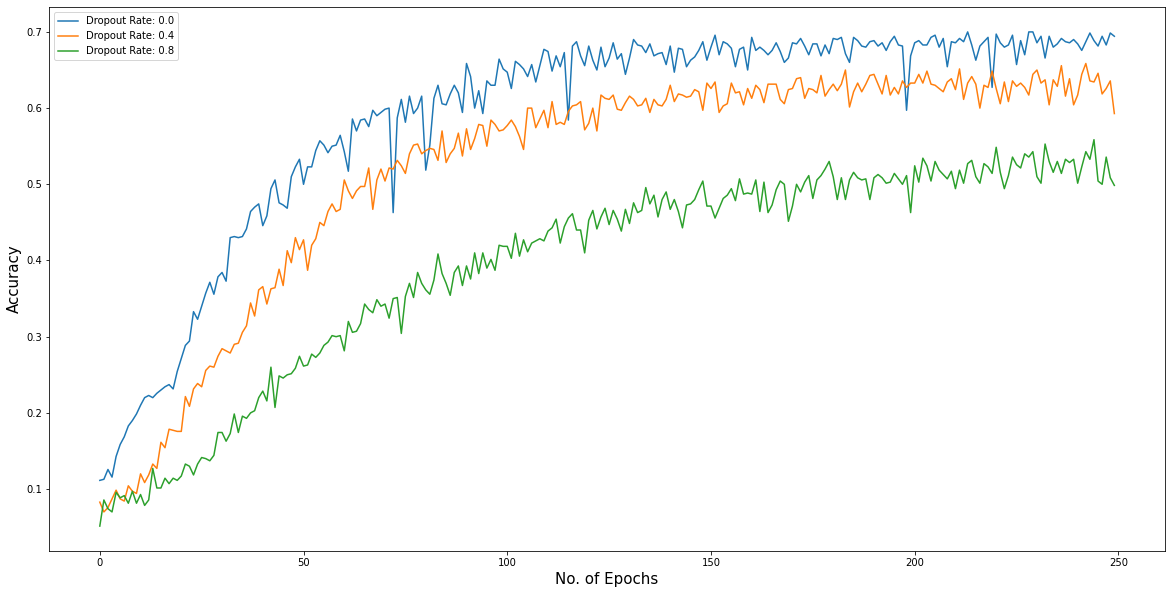

In [ ]:
# Training Character CNN with dropout

plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), test_acc_q1, label="Dropout Rate: 0.0")

for DROP_RATE in DROP_RATES:
  
  model = CharCNN(256)

  # Training and testing the model
  train_cost_current = []
  test_acc_current = []

  train_cost_current, test_acc_current, time_current = train_and_test(model, True, True, DROP_RATE)

  # Plotting testing accuracy vs. epochs
  plt.plot(np.arange(EPOCHS), test_acc_current, label=f"Dropout Rate: {DROP_RATE}")

plt.xlabel('No. of Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

Character CNN

- 0.0 dropout rate - 69.4% accuracy
- 0.4 dropout rate - 59.7% accuracy
- 0.8 dropout rate - 49.8% accuracy

Epoch 10, Loss: 2.688265085220337, Accuracy: 0.06732142716646194, Test Loss: 2.6900625228881836, Test Accuracy: 0.0657142847776413
Epoch 20, Loss: 2.674482583999634, Accuracy: 0.07071428745985031, Test Loss: 2.675722122192383, Test Accuracy: 0.0714285746216774
Epoch 30, Loss: 2.666464328765869, Accuracy: 0.07785714417695999, Test Loss: 2.6712100505828857, Test Accuracy: 0.06714285910129547
Epoch 40, Loss: 2.6585047245025635, Accuracy: 0.07357142865657806, Test Loss: 2.660005807876587, Test Accuracy: 0.07999999821186066
Epoch 50, Loss: 2.646169662475586, Accuracy: 0.08821428567171097, Test Loss: 2.6450979709625244, Test Accuracy: 0.1128571406006813
Epoch 60, Loss: 2.6315441131591797, Accuracy: 0.0994642823934555, Test Loss: 2.6292965412139893, Test Accuracy: 0.09714286029338837
Epoch 70, Loss: 2.6252317428588867, Accuracy: 0.10035714507102966, Test Loss: 2.6219913959503174, Test Accuracy: 0.1014285683631897
Epoch 80, Loss: 2.617250680923462, Accuracy: 0.09553571790456772, Test Loss: 2.6

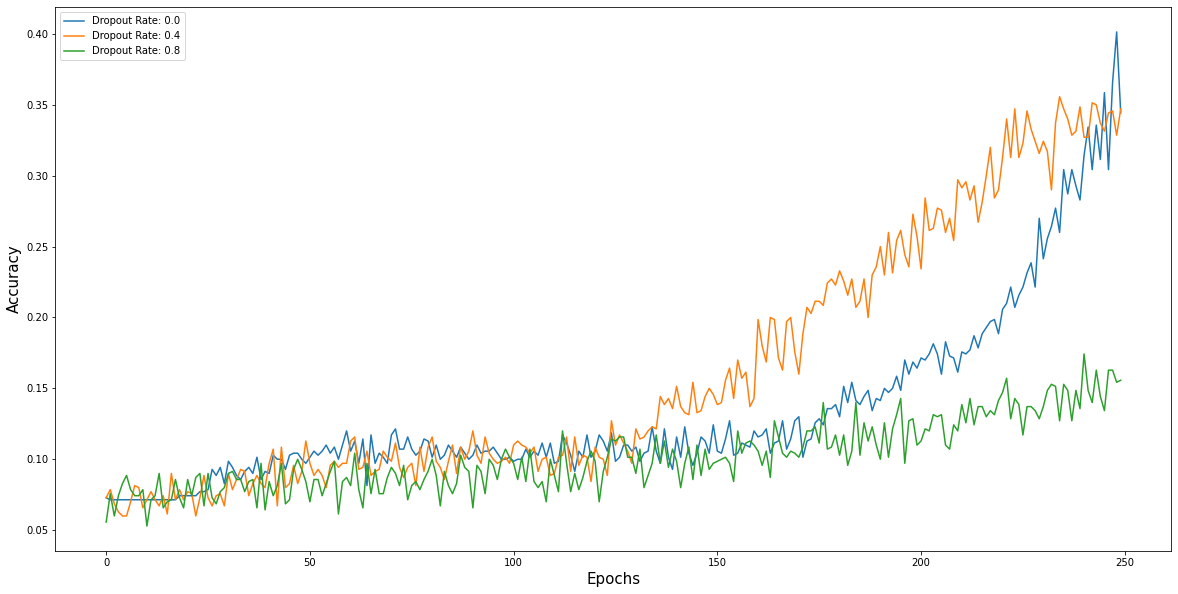

In [ ]:
# Training Word CNN with dropout

plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), test_acc_q2, label="Dropout Rate: 0.0")

for DROP_RATE in DROP_RATES:
  # Building the model object
  model = WordCNN(vocab_size_word)

  # Training and testing the model
  train_cost_current = []
  test_acc_current = []

  train_cost_current, test_acc_current, time_current = train_and_test(model, True, False, DROP_RATE)


  # Plotting testing accuracy vs. epochs
  plt.plot(np.arange(EPOCHS), test_acc_current, label=f"Dropout Rate: {DROP_RATE}")

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

Word CNN

- 0.0 dropout rate - 34.4% accuracy
- 0.4 dropout rate - 34.7% accuracy
- 0.8 dropout rate - 15.5% accuracy

Epoch 10, Loss: 1.4668487310409546, Accuracy: 0.4705357253551483, Test Loss: 1.5427881479263306, Test Accuracy: 0.48571428656578064
Epoch 20, Loss: 1.3288840055465698, Accuracy: 0.5237500071525574, Test Loss: 1.4967085123062134, Test Accuracy: 0.49714285135269165
Epoch 30, Loss: 1.0198441743850708, Accuracy: 0.6153571605682373, Test Loss: 1.252827525138855, Test Accuracy: 0.581428587436676
Epoch 40, Loss: 0.9046650528907776, Accuracy: 0.6621428728103638, Test Loss: 1.214980959892273, Test Accuracy: 0.6157143115997314
Epoch 50, Loss: 0.8457622528076172, Accuracy: 0.685535728931427, Test Loss: 1.1890541315078735, Test Accuracy: 0.6428571343421936
Epoch 60, Loss: 0.8052465319633484, Accuracy: 0.7024999856948853, Test Loss: 1.214292049407959, Test Accuracy: 0.6214285492897034
Epoch 70, Loss: 0.7572963237762451, Accuracy: 0.7241071462631226, Test Loss: 1.1930721998214722, Test Accuracy: 0.654285728931427
Epoch 80, Loss: 0.7023317813873291, Accuracy: 0.7425000071525574, Test Loss: 1.20507466

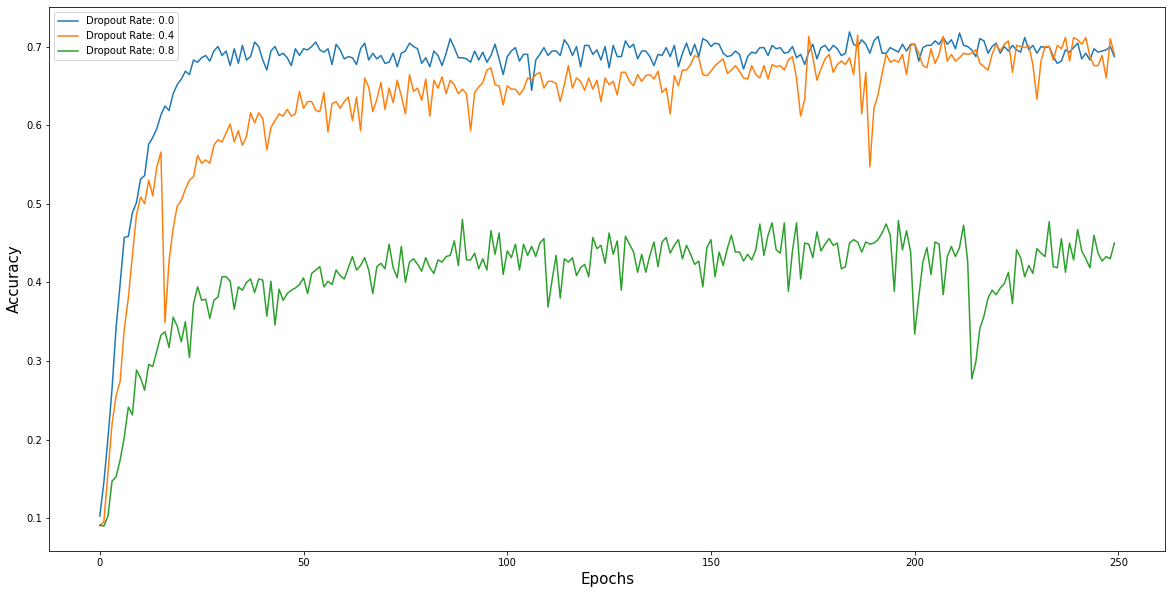

In [ ]:
# Training Character RNN with dropout

plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), test_acc_q3, label="Dropout Rate: 0.0")

for DROP_RATE in DROP_RATES:
  # Building the model object
  model = CharacterRNN(HIDDEN_SIZE)

  # Training and testing the model
  train_cost_current = []
  test_acc_current = []

  train_cost_current, test_acc_current, time_current = train_and_test(model, False, True, DROP_RATE)

  # Plotting testing accuracy vs. epochs
  plt.plot(np.arange(EPOCHS), test_acc_current, label=f"Dropout Rate: {DROP_RATE}")

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

Character RNN

- 0.0 dropout rate - 71.4% accuracy
- 0.4 dropout rate - 68.9% accuracy
- 0.8 dropout rate - 44.9% accuracy

Epoch 10, Loss: 0.3887960612773895, Accuracy: 0.8944643139839172, Test Loss: 1.008622407913208, Test Accuracy: 0.7900000214576721
Epoch 20, Loss: 0.10460081696510315, Accuracy: 0.9721428751945496, Test Loss: 0.913706362247467, Test Accuracy: 0.8628571629524231
Epoch 30, Loss: 0.042536575347185135, Accuracy: 0.9882143139839172, Test Loss: 1.0899535417556763, Test Accuracy: 0.8614285588264465
Epoch 40, Loss: 0.031487371772527695, Accuracy: 0.9910714030265808, Test Loss: 1.3166007995605469, Test Accuracy: 0.8428571224212646
Epoch 50, Loss: 0.02914060465991497, Accuracy: 0.991428554058075, Test Loss: 1.2591352462768555, Test Accuracy: 0.8500000238418579
Epoch 60, Loss: 0.0234057679772377, Accuracy: 0.9937499761581421, Test Loss: 1.4234100580215454, Test Accuracy: 0.8514285683631897
Epoch 70, Loss: 0.025640500709414482, Accuracy: 0.9923214316368103, Test Loss: 1.4589905738830566, Test Accuracy: 0.8385714292526245
Epoch 80, Loss: 0.07671564817428589, Accuracy: 0.977142870426178, Test Loss: 1

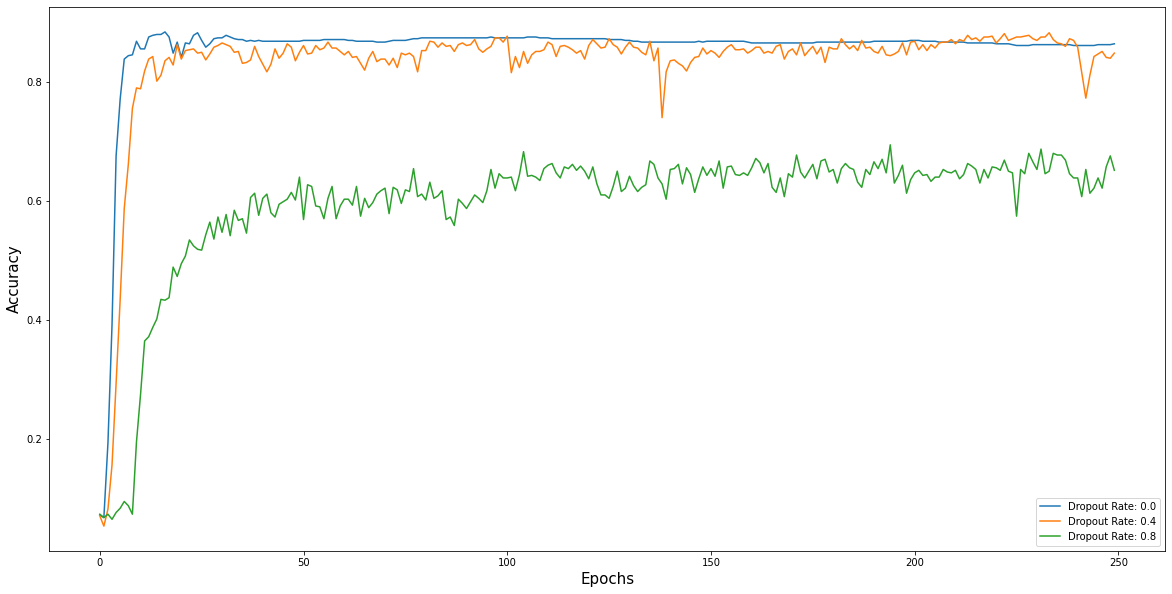

In [ ]:
# Training word RNN with dropout

plt.figure(figsize=(20,10))
plt.plot(np.arange(EPOCHS), test_acc_q4, label="Dropout Rate: 0.0")

for DROP_RATE in DROP_RATES:
  # Building the model object
  model = WordRNN(vocab_size_word, HIDDEN_SIZE)

  # Training and testing the model
  train_cost_current = []
  test_acc_current = []

  train_cost_current, test_acc_current, time_current = train_and_test(model, False, False, DROP_RATE)

  # Plotting testing accuracy vs. epochs
  plt.plot(np.arange(EPOCHS), test_acc_current, label=f"Dropout Rate: {DROP_RATE}")

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

Word RNN

- 0.0 dropout rate - 86.4% accuracy
- 0.4 dropout rate - 84.8% accuracy
- 0.8 dropout rate - 65.1% accuracy

## Question 6


###6A. Updating the Character RNN Classifier

In [ ]:
# Defining the training function
def train_step_new(model, x, label, drop_rate=0.0):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Defining the testing function
def test_step_new(model, x, label, drop_rate=0.0):
    out = model(x, drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [ ]:
max_accuracies_crnn = {}

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20,20))

row = 0
for curNumLayers in numLayers:
  for curUseClipping in useClipping:
    for curCol in range(len(typeLayers)):
      curLayerType = typeLayers[curCol]

      # Building the model object
      model = CharacterRNN(HIDDEN_SIZE, cell_type=curLayerType, rnn_layers=curNumLayers)

      # Choose optimizer and loss function for training
      if curUseClipping:
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR, clipvalue=2.0)
      else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
      loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

      # Select metrics to measure the loss and the accuracy of the model. 
      # These metrics accumulate the values over epochs and then print the overall result.
      train_loss = tf.keras.metrics.Mean(name='train_loss')
      train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

      test_loss = tf.keras.metrics.Mean(name='test_loss')
      test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

      # Training and testing the model
      test_acc_model = []

      with tf.device('/device:GPU:0'):
        for epoch in range(EPOCHS):
            # Reset the metrics at the start of the next epoch
            train_loss.reset_states()
            train_accuracy.reset_states()
            test_loss.reset_states()
            test_accuracy.reset_states()

            for images, labels in train_ds_word:
                train_step_new(model, images, labels)

            for images, labels in test_ds_word:
                test_step_new(model, images, labels)

            test_acc_model.append(test_accuracy.result())
          
      print(f"Layer Type: {curLayerType}, Num. of Layers: {curNumLayers}, useClipping: {curUseClipping}, Accuracy = {test_accuracy.result()}")

      axs[row, curCol].plot(np.arange(EPOCHS), test_acc_model, label="Test Accuracy")
      axs[row, curCol].set_title(f"Type: {curLayerType}, Layers: {curNumLayers}, Clipping: {curUseClipping}")
      axs[row, curCol].set_xlabel('Epochs')
      axs[row, curCol].set_ylabel('Accuracy')
      
      max_accuracies_crnn[f"{curLayerType}_{curNumLayers}_{curUseClipping}"] = max(test_acc_model)
    row += 1   
plt.show()   

Layer Type: GRU, Num. of Layers: 1, useClipping: False, Accuracy = 0.8142856955528259
Layer Type: RNN, Num. of Layers: 1, useClipping: False, Accuracy = 0.822857141494751
Layer Type: LTSM, Num. of Layers: 1, useClipping: False, Accuracy = 0.8514285683631897
Layer Type: GRU, Num. of Layers: 1, useClipping: True, Accuracy = 0.8285714387893677
Layer Type: RNN, Num. of Layers: 1, useClipping: True, Accuracy = 0.8371428847312927
Layer Type: LTSM, Num. of Layers: 1, useClipping: True, Accuracy = 0.8414285778999329
Layer Type: GRU, Num. of Layers: 2, useClipping: False, Accuracy = 0.8214285969734192


The above cell exeuction was executed in a parallel window because of time and resource constraints. The results are included in the report.

### 6B. Updating the Word RNN Classifier

Type: GRU, Layers: 1, Clipping: False, Accuracy = 0.8214285969734192
Type: RNN, Layers: 1, Clipping: False, Accuracy = 0.8357142806053162
Type: LTSM, Layers: 1, Clipping: False, Accuracy = 0.8714285492897034
Type: GRU, Layers: 1, Clipping: True, Accuracy = 0.8285714387893677
Type: RNN, Layers: 1, Clipping: True, Accuracy = 0.845714271068573
Type: LTSM, Layers: 1, Clipping: True, Accuracy = 0.8214285969734192
Type: GRU, Layers: 2, Clipping: False, Accuracy = 0.8700000047683716
Type: RNN, Layers: 2, Clipping: False, Accuracy = 0.8899999856948853
Type: LTSM, Layers: 2, Clipping: False, Accuracy = 0.8471428751945496
Type: GRU, Layers: 2, Clipping: True, Accuracy = 0.8471428751945496
Type: RNN, Layers: 2, Clipping: True, Accuracy = 0.881428599357605
Type: LTSM, Layers: 2, Clipping: True, Accuracy = 0.8628571629524231


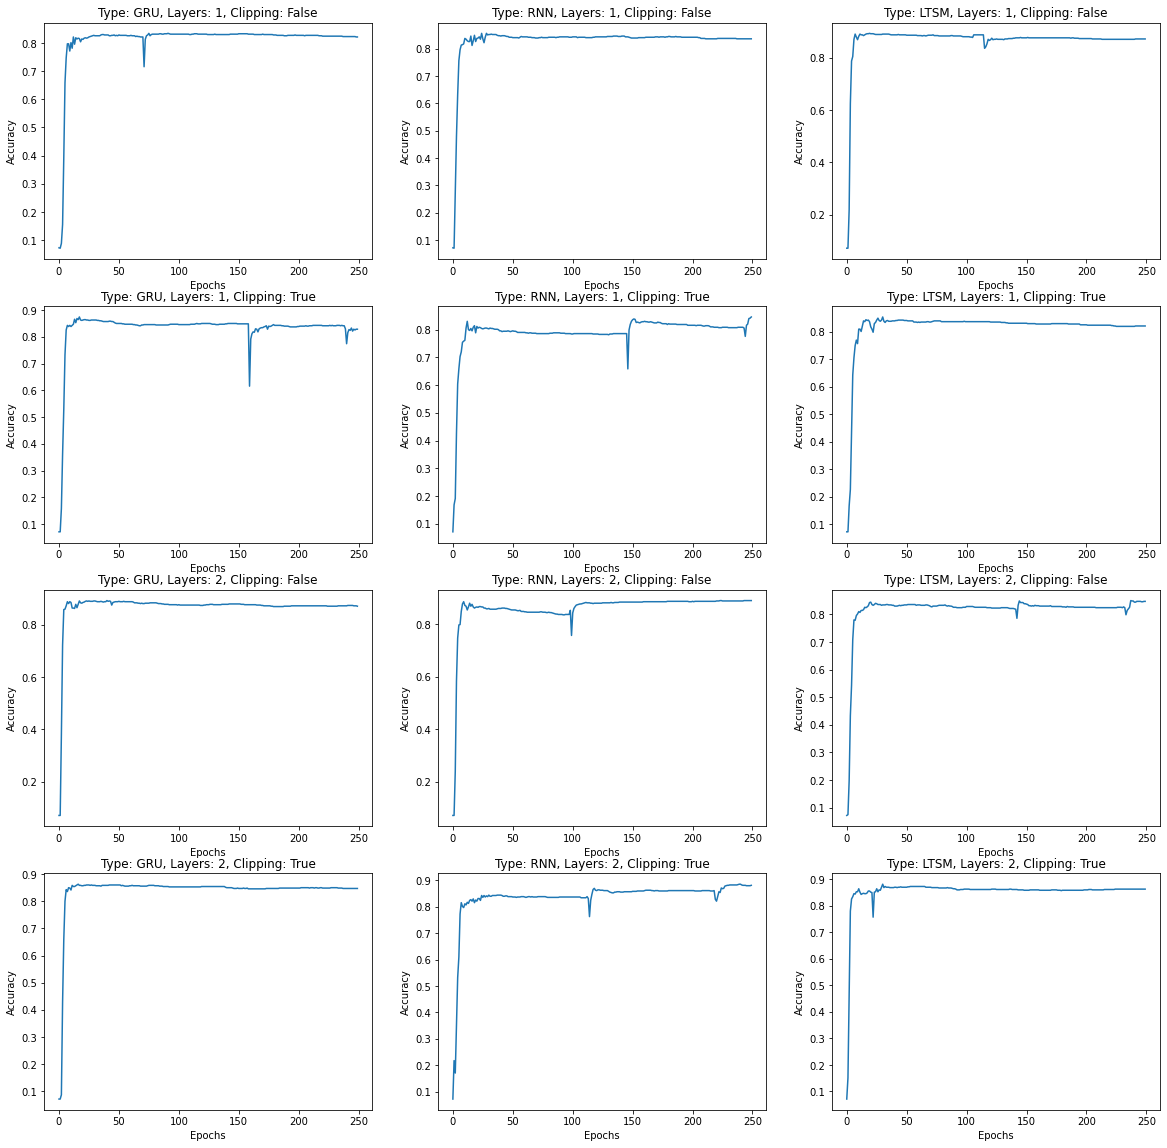

In [ ]:
max_accuracies_wrnn = {}

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20,20))

row = 0

for curNumLayers in numLayers:
  for curUseClipping in useClipping:
    for curCol in range(len(typeLayers)):
      curLayerType = typeLayers[curCol]

      # Building the model object
      model = WordRNN(vocab_size_word, HIDDEN_SIZE)

      # Choose optimizer and loss function for training
      if curUseClipping:
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR, clipvalue=2.0)
      else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
      loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

      # Select metrics to measure the loss and the accuracy of the model. 
      # These metrics accumulate the values over epochs and then print the overall result.
      train_loss = tf.keras.metrics.Mean(name='train_loss')
      train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

      test_loss = tf.keras.metrics.Mean(name='test_loss')
      test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

      # Training and testing the model
      test_acc_model = []

      with tf.device('/device:GPU:0'):
        for epoch in range(EPOCHS):
            # Reset the metrics at the start of the next epoch
            train_loss.reset_states()
            train_accuracy.reset_states()
            test_loss.reset_states()
            test_accuracy.reset_states()

            for images, labels in train_ds_word:
                train_step_new(model, images, labels)

            for images, labels in test_ds_word:
                test_step_new(model, images, labels)

            test_acc_model.append(test_accuracy.result())
          
      print(f"Type: {curLayerType}, Layers: {curNumLayers}, Clipping: {curUseClipping}, Accuracy = {test_accuracy.result()}")
      axs[row, curCol].plot(np.arange(EPOCHS), test_acc_model, label="Test Accuracy")
      axs[row, curCol].set_title(f"Type: {curLayerType}, Layers: {curNumLayers}, Clipping: {curUseClipping}")
      axs[row, curCol].set_xlabel('Epochs')
      axs[row, curCol].set_ylabel('Accuracy')
      max_accuracies_wrnn[f"{curLayerType}_{curNumLayers}_{curUseClipping}"] = max(test_acc_model)
    row += 1   
plt.show()   